# Perform tracking using Trackpy

In [9]:
# Load python modules used in the following
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy
from skimage import measure # to get object contours from masks

import tqdm
import pims
import trackpy as tp  # we use trackpy module for tracking

import imagecodecs
import napari

# I. Load segmentation results).

In [77]:
os.chdir("D:\Hugo\Migration")  # root dir containg Predictions and Images Path
predictions_path = "Predictions/Sd_versatile_Position2_2048x2048.tif"
corresponding_imgs = "Position2/Position2.tif"

predictions = imageio.volread(predictions_path)
# predictions = pims.open(predictions_path)
imgs = imageio.volread(corresponding_imgs)

# II. Get objects from contours

The segmentation step (using a neural network) outputs a mask. Each mask has the same dimensions as the input image, and background pixels have a grey level of 0. All the pixels grouped within the same object (i.e. cell nucleus) have the same grey level, and they are the only pixels on the image to have this level. Now we want to retrieve the contours and centroid of the objects at each frame from the masks.

### Retrieve object contours using skimage

0it [00:00, ?it/s]

This step should take around 1 minutes for 50 frames (50 it.)


40it [00:32,  1.14s/it]

CAUTION: More than one object detected per grey level : 2 objects!


44it [00:37,  1.25s/it]

CAUTION: More than one object detected per grey level : 2 objects!


51it [00:46,  1.40s/it]

CAUTION: More than one object detected per grey level : 2 objects!


54it [00:51,  1.05it/s]


Done. Retrieved contours for 54 frames.
Sanity check : the contours should be well superimposed with the objects.


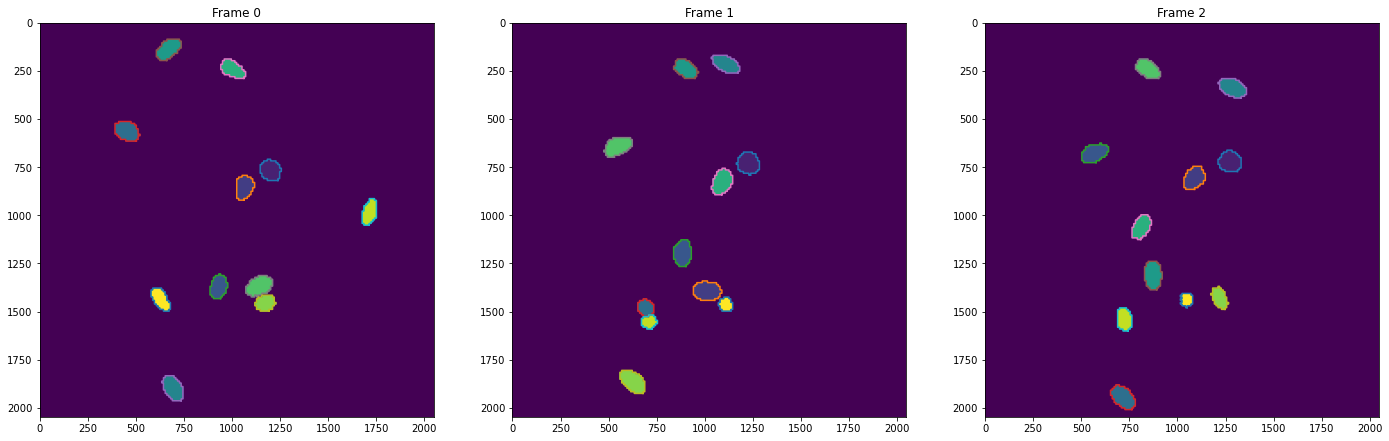

In [78]:
# importing colors
import matplotlib.colors as mcolors
by_hsv = [(tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                         name)
                        for name, color in mcolors.TABLEAU_COLORS.items()]
names = [name for hsv, name in by_hsv]

# retrieving contours at each frame
print("This step should take around 1 minutes for 50 frames (50 it.)")
all_contours = []
for i, m in tqdm.tqdm(enumerate(predictions)):  # iterating on frames

    all_contours_at_this_frame = []
    for gray_level in np.unique(m)[1:]:  # iterating on grey levels in each frame. Don't take 0 as it is the background
        obj = np.array(m == gray_level, dtype=np.uint8)  # only pixels with this intensity = one specific object
        contours = measure.find_contours(obj, level=0.99)  # list of contours

        if len(contours) > 1:
            print(f"CAUTION: More than one object detected per grey level : {len(contours)} objects!")

        all_contours_at_this_frame.append(contours[0])  # only one object per grey level, list of objects per frame
    all_contours_at_this_frame = np.array(all_contours_at_this_frame, dtype=np.object)  # one array per frame
    all_contours.append(all_contours_at_this_frame) 

all_contours = np.array(all_contours, dtype=np.object)  # array of frames of objects

print(f"Done. Retrieved contours for {all_contours.shape[0]} frames.")

# Plot several frames with the object and the retrieved contours.
print("Sanity check : the contours should be well superimposed with the objects.")
init_idx, nb_frames = 0, 3
fig, axes = plt.subplots(1, nb_frames, figsize=(8 * nb_frames, 8))
for idx, (mask, contours, ax) in enumerate(zip(predictions[init_idx:init_idx+nb_frames], all_contours[init_idx:init_idx+nb_frames], axes)):
    ax.set_title(f"Frame {init_idx + idx}")
    ax.imshow(mask)

    for contour in contours:
        ax.plot(contour[:, 1], contour[:, 0])

### From the contours retrieve the centroid (barycenter) of each object

The centroid of each object will be used in the tracking step.

(722, 3)
The barycenters (coloured dots) should be well superimposed with the objects.


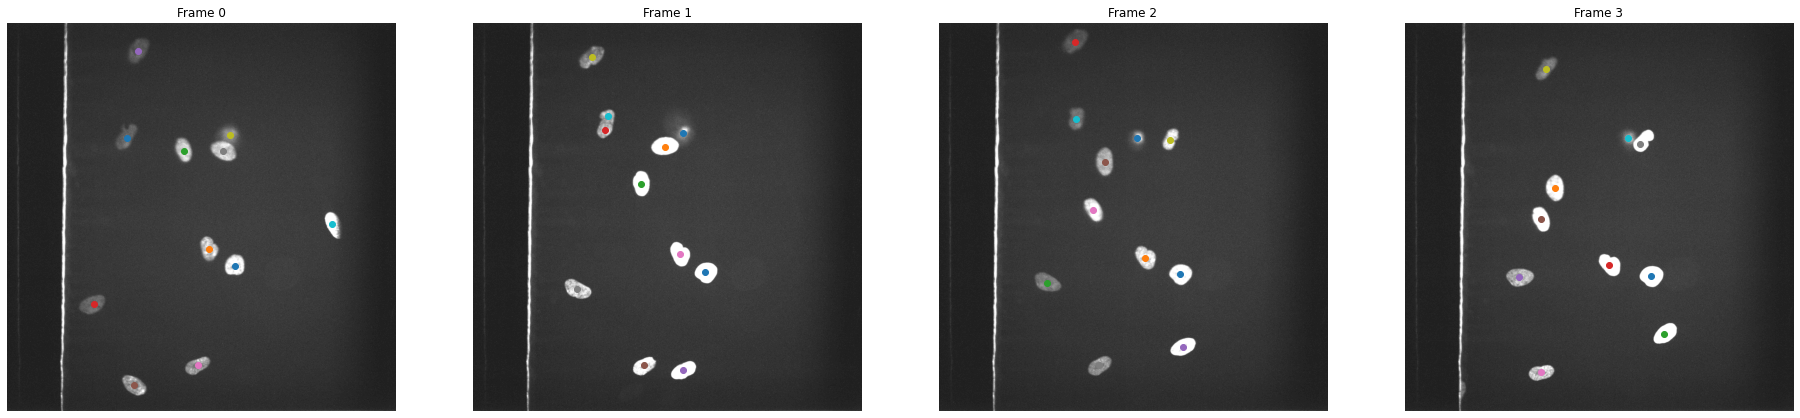

In [79]:
# retrieve all barycenters and build a datastructure for trackpy
positions_at_frames = []
for i, frame in enumerate(all_contours):
    for cell in frame:
        positions_at_frames.append({"frame": i, "x": np.sum(cell[:, 1]) / cell.shape[0], "y": np.sum(cell[:, 0]) / cell.shape[0]})
positions_per_frame = pd.DataFrame(positions_at_frames)

# check the shape
print(positions_per_frame.shape)

# Display the image and plot the barycenters to check if they're correctly positioned
nb_imgs = 4
fig, ax = plt.subplots(1, nb_imgs, figsize=(8 * nb_imgs, 8))

print("The barycenters (coloured dots) should be well superimposed with the objects.")

for i, (contour_im, im) in enumerate(zip(all_contours[:nb_imgs], imgs[:nb_imgs])):
#     ax[i].imshow(cv2.resize(im, (512, 512)), cmap="gray", origin="lower")
    ax[i].imshow(im, cmap="gray", origin="lower")
    for idx, cell in positions_per_frame[positions_per_frame["frame"] == i].iterrows():
        x, y = cell["x"], cell["y"]
        ax[i].scatter(x, y)
    ax[i].axis("off")
    ax[i].set_title(f"Frame {i}")

The datastructure used to perform the tracking step is a table, with the (x, y, t) coordinates of the objects. 

In [80]:
positions_per_frame.head()

frame            x            y
0      0  1200.337808   764.731566
1      0  1066.160356   855.055702
2      0   930.393736  1370.272953
3      0   455.055437   563.422196
4      0   691.340206  1897.927856

# III. Peform tracking using the surface and position of each cell at each time point

The tracking step outputs a table containing for each object, its (x, y, t) coordinates as well as a label that links the different positions of the same object over time.

In [81]:
# perform the tracking step
max_search_radius = 300  # maximum distance made by
tracks = tp.link(positions_per_frame, max_search_radius, memory=1)

# reformat the tracking results to display them
tracks_to_napari = []
for i, track in tracks.iterrows():
    tracks_to_napari.append({"ID": track["particle"], "Frame": track["frame"], "X": track["y"], "Y": track["x"]})
tracks_to_napari = pd.DataFrame(tracks_to_napari)

tracks_to_napari.head()

Frame 53: 22 trajectories present.


ID  Frame            X            Y
0  0.0    0.0   764.731566  1200.337808
1  1.0    0.0   855.055702  1066.160356
2  2.0    0.0  1370.272953   930.393736
3  3.0    0.0   563.422196   455.055437
4  4.0    0.0  1897.927856   691.340206

In [82]:
# saving the tracking results
save_path = "D:/Hugo/Migration/Position2_tracking_results.csv"
tracks.to_csv(save_path, sep=",", index=False)

In [83]:
print("Displaying tracks in napari (a new window should open).")

viewer = napari.view_image(imgs, name="Images", opacity=0.8)
viewer.add_image(predictions * 255, opacity=1.0, colormap="blue", blending="additive", name="Segmentation")
viewer.add_tracks(tracks_to_napari, name="Tracks")

Displaying tracks in napari (a new window should open).


<Tracks layer 'Tracks' at 0x18300e0deb0>

# IV. Tracking results analysis

See trackpy documentation for some ideas : 
- http://soft-matter.github.io/trackpy/v0.5.0/tutorial/walkthrough.html